In [ ]:
import pandas as pd

df = pd.read_csv('merged_random50_discharge_prescriptions.csv')

columns_to_convert = ['drug', 'dose_val_rx', 'dose_unit_rx', 'route', 'form_unit_disp']

def parse_list_as_strings(x):
    if pd.isna(x):
        return []
    x = x.strip('[]')
    items = x.split(',')
    # Clean up each item and return as a list of strings
    return [item.strip().strip('"').strip("'") for item in items]

for col in columns_to_convert:
    df[col] = df[col].apply(parse_list_as_strings)

def build_drug_info(drugs, doses, units, routes, forms):
    drug_info = {}
    for drug, dose, unit, route, form in zip(drugs, doses, units, routes, forms):
        if drug not in drug_info:
            drug_info[drug] = {'dose': [], 'unit': [], 'route': [], 'form': []}
        drug_info[drug]['dose'].append(dose)
        drug_info[drug]['unit'].append(unit)
        drug_info[drug]['route'].append(route)
        drug_info[drug]['form'].append(form)
    return drug_info

df['Drug_Info'] = df.apply(
    lambda row: build_drug_info(row['drug'], row['dose_val_rx'], row['dose_unit_rx'], row['route'], row['form_unit_disp']),
    axis=1
)

print(df['Drug_Info'].iloc[0])  # Display the first row's drug info dictionary

df.to_csv('prescriptions_table_with_formatted_columns.csv')


{'CloniDINE': {'dose': ['0.1', '0.1'], 'unit': ['mg', 'mg'], 'route': ['PO', 'PO'], 'form': ['TAB', 'TAB']}, 'Nicotine Polacrilex': {'dose': ['1'], 'unit': ['STCK'], 'route': ['PO'], 'form': ['STCK']}, 'Oxcarbazepine': {'dose': ['150'], 'unit': ['mg'], 'route': ['PO'], 'form': ['TAB']}, 'DiphenhydrAMINE': {'dose': ['25', '50', '50', '25'], 'unit': ['mg', 'mg', 'mg', 'mg'], 'route': ['PO/NG', 'PO/NG', 'PO', 'PO'], 'form': ['CAP', 'CAP', 'CAP', 'CAP']}, 'Albuterol Inhaler': {'dose': ['1'], 'unit': ['PUFF'], 'route': ['IH'], 'form': ['INH']}, 'Lorazepam': {'dose': ['2', '2', '1', '1.5', '0.5', '2'], 'unit': ['mg', 'mg', 'mg', 'mg', 'mg', 'mg'], 'route': ['PO', 'PO', 'PO', 'PO', 'PO', 'PO'], 'form': ['TAB', 'TAB', 'TAB', 'TAB', 'TAB', 'TAB']}, 'Triamcinolone Acetonide 0.025% Cream': {'dose': ['1'], 'unit': ['Appl'], 'route': ['TP'], 'form': ['TUBE']}, 'Amitriptyline': {'dose': ['50', '100', '25'], 'unit': ['mg', 'mg', 'mg'], 'route': ['PO', 'PO', 'PO/NG'], 'form': ['TAB', 'TAB', 'TAB']}, '

Now, this turns it from that dictionary to group each dose, unit, route, and form together in a tuple for comparison later

In [ ]:
##Convert to tuple format
def convert_to_tuple_format(drug_info):
    converted = {}
    for drug, info in drug_info.items():
        # Create a list of tuples: (dose, unit, route, form) all as strings
        converted[drug] = [(str(dose), str(unit), str(route), str(form)) for dose, unit, route, form in zip(info['dose'], info['unit'], info['route'], info['form'])]
    return converted

df['Drug_Info_Tuple'] = df['Drug_Info'].apply(convert_to_tuple_format)

print(df['Drug_Info_Tuple'].iloc[0])
df.to_csv('prescriptions_table_with_formatted_columns.csv')

{'CloniDINE': [('0.1', 'mg', 'PO', 'TAB'), ('0.1', 'mg', 'PO', 'TAB')], 'Nicotine Polacrilex': [('1', 'STCK', 'PO', 'STCK')], 'Oxcarbazepine': [('150', 'mg', 'PO', 'TAB')], 'DiphenhydrAMINE': [('25', 'mg', 'PO/NG', 'CAP'), ('50', 'mg', 'PO/NG', 'CAP'), ('50', 'mg', 'PO', 'CAP'), ('25', 'mg', 'PO', 'CAP')], 'Albuterol Inhaler': [('1', 'PUFF', 'IH', 'INH')], 'Lorazepam': [('2', 'mg', 'PO', 'TAB'), ('2', 'mg', 'PO', 'TAB'), ('1', 'mg', 'PO', 'TAB'), ('1.5', 'mg', 'PO', 'TAB'), ('0.5', 'mg', 'PO', 'TAB'), ('2', 'mg', 'PO', 'TAB')], 'Triamcinolone Acetonide 0.025% Cream': [('1', 'Appl', 'TP', 'TUBE')], 'Amitriptyline': [('50', 'mg', 'PO', 'TAB'), ('100', 'mg', 'PO', 'TAB'), ('25', 'mg', 'PO/NG', 'TAB')], 'Zolpidem Tartrate': [('10', 'mg', 'PO', 'TAB')], 'Multivitamins': [('1', 'TAB', 'PO/NG', 'TAB')], 'Acetaminophen': [('650', 'mg', 'PO', 'TAB')], 'Hydrocortisone Cream 1%': [('1', 'Appl', 'TP', 'TUBE')], 'Aluminum-Magnesium Hydrox.-Simethicone': [('30', 'mL', 'PO', 'UDCUP')], 'Fexofenadine'

This does the same thing as above, except now for LLM output and not ground truth output

In [ ]:
import pandas as pd
from collections import defaultdict



#to make proportion metrics for these below, use the correct file in the model_df in next lines
baseline_file = "cleaned_extracted_medical_info_baseline.csv"
annotation_file = "cleaned_extracted_medical_info_annotation.csv"
doctor_file = "cleaned_extracted_medical_info_doctor.csv"
ner_file = "cleaned_extracted_medical_info_drugs_2.csv"
error_file = "cleaned_extracted_medical_info_error.csv"
scribe_file = "cleaned_extracted_medical_info_scribe.csv"

model_df = pd.read_csv('cleaned_extracted_medical_info_drugs.csv')


patient_drug_tuples = defaultdict(lambda: defaultdict(list))

for idx, row in model_df.iterrows():
    patient_id = row['Patient Index']  
    drug = str(row['Drug Name']).strip()  
    dose = str(row['Drug Dosage']).strip()
    unit = str(row['Unit of Measurement of Dosage']).strip()
    form = str(row['Drug Form']).strip()
    route = str(row['Route']).strip()

    patient_drug_tuples[patient_id][drug].append((dose, unit, form, route))

patients_list = []
for patient_id, drug_dict in patient_drug_tuples.items():
    patients_list.append({
        'Patient Index': patient_id,
        'drug_tuples_dict': drug_dict
    })

llm_df = pd.DataFrame(patients_list)


llm_df["drug_tuples_dict"].iloc[1]


defaultdict(list,
            {'Calcitriol': [('Not mentioned',
               'Not mentioned',
               'Not mentioned',
               'Not mentioned'),
              ('0.25', 'mcg', 'Not mentioned', 'PO')],
             'PhosLo': [('1334', 'mg', 'Not mentioned', 'Not mentioned')],
             'Acetaminophen': [('650', 'mg', 'Not mentioned', 'PO'),
              ('650', 'mg', 'Not mentioned', 'PO')],
             'Amlodipine': [('5', 'mg', 'Not mentioned', 'PO'),
              ('5', 'mg', 'Not mentioned', 'PO')],
             'Aspirin': [('81', 'mg', 'Not mentioned', 'PO'),
              ('81', 'mg', 'Not mentioned', 'PO')],
             'Atorvastatin': [('40', 'mg', 'Not mentioned', 'PO'),
              ('40', 'mg', 'Not mentioned', 'PO')],
             'Citalopram': [('20', 'mg', 'Not mentioned', 'PO'),
              ('20', 'mg', 'Not mentioned', 'PO')],
             'Docusate Sodium': [('100', 'mg', 'Not mentioned', 'PO'),
              ('100', 'mg', 'Not mentioned', 'PO')]

In [94]:
import numpy as np

def jaccard_similarity_case_insensitive(tuple1, tuple2):
    """Compute Jaccard similarity between two tuples of strings, ignoring case."""
    set1 = set(str(x).lower() for x in tuple1)
    set2 = set(str(x).lower() for x in tuple2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def match_and_score_tuples(model_tuples, ground_truth_tuples):
    """
    Matches tuples between model and ground truth using maximum Jaccard similarity,
    and computes the average similarity, number of hallucinations, and misses.
    """
    model_tuples = list(model_tuples)  # Ensure lists
    ground_truth_tuples = list(ground_truth_tuples)
    
    n_model = len(model_tuples)
    n_gt = len(ground_truth_tuples)
    
    if n_model == 0 and n_gt == 0:
        return 1.0, 0, 0  # Perfect match if nothing predicted and nothing to find

    # Build similarity matrix
    sim_matrix = np.zeros((n_model, n_gt))
    for i, model_tuple in enumerate(model_tuples):
        for j, gt_tuple in enumerate(ground_truth_tuples):
            sim_matrix[i, j] = jaccard_similarity_case_insensitive(model_tuple, gt_tuple)
    
    matched_model = set()
    matched_gt = set()
    matches = []

    while True:
        # Find the max similarity pair
        max_sim = -1
        max_i, max_j = -1, -1
        for i in range(n_model):
            if i in matched_model:
                continue
            for j in range(n_gt):
                if j in matched_gt:
                    continue
                if sim_matrix[i, j] > max_sim:
                    max_sim = sim_matrix[i, j]
                    max_i, max_j = i, j
        
        if max_sim <= 0:
            break  # No more good matches

        matched_model.add(max_i)
        matched_gt.add(max_j)
        matches.append(max_sim)

    num_hallucinations = n_model - len(matched_model)
    num_misses = n_gt - len(matched_gt)
    average_similarity = np.mean(matches) if matches else 0.0

    return float(average_similarity), num_hallucinations, num_misses


In [ ]:
##Doing the metric calculations for similarity simply between the drugs from gemini and the EHR drugs

def proportion_overlap(set1, set2):
    """
    Compute the proportion of elements in set1 that exist in set2 (case insensitive).

    Args:
        set1 (iterable): First set/list of elements.
        set2 (iterable): Second set/list of elements.

    Returns:
        float: Proportion of set1 elements that are found in set2.
    """
    # Normalize everything to strings, lowercase, and strip
    set1 = {str(e).lower().strip() for e in set1}
    set2 = {str(e).lower().strip() for e in set2}
    
    if len(set1) == 0:
        return 0.0  # Avoid division by zero

    intersection = set1 & set2

    return len(intersection) / len(set1)

prop_sum = 0
for i in range(len(llm_df)):    
    prop_sum += proportion_overlap(llm_df['drug_tuples_dict'].iloc[i].keys(), df['Drug_Info_Tuple'].iloc[i].keys())
avg_prop = prop_sum/len(llm_df)

ner_prop = avg_prop
ner_prop

#all different variables are: baseline_prop, annotation_prop, doctor_prop, error_prop, scribe_prop, ner_prop


0.15039957063773907

In [ ]:
#Given two drug dictionaries, find overlapping drugs, and then see how those tuples overlap generally
def compare_drug_dicts(model_dict, ground_truth_dict):
    """
    Compare two drug dictionaries and compute matching metrics (case-insensitive).

    Args:
        model_dict (dict): {drug: list of 4-tuples} from model
        ground_truth_dict (dict): {drug: list of 4-tuples} from ground truth

    Returns:
        dict: mapping drug -> {'avg_jaccard', 'hallucinations', 'misses'}
    """
    results = {}

    model_dict_lower = {drug.lower(): mentions for drug, mentions in model_dict.items()}
    ground_truth_dict_lower = {drug.lower(): mentions for drug, mentions in ground_truth_dict.items()}

    # Find matching drugs
    common_drugs = set(model_dict_lower.keys()) & set(ground_truth_dict_lower.keys())
    
    for drug in common_drugs:
        tuples1 = model_dict_lower[drug]
        tuples2 = ground_truth_dict_lower[drug]
        metrics = match_and_score_tuples(tuples1, tuples2)
        results[drug] = metrics

    return results

In [8]:
from sklearn.model_selection import train_test_split
# make train test split for the fine tuning and validation
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Now train_df and test_df are your training and testing sets
print("Train DataFrame:")
train_df.head()


Train DataFrame:


,subject_id,hadm_id,text,charttime,drug,dose_val_rx,dose_unit_rx,route,form_unit_disp,Drug_Info,Drug_Info_Tuple
48,17653539,29073906,\nName: ___ Unit No: ___\n ...,2181-12-18 00:00:00,"[Diazepam, Acetaminophen, Simvastatin, Senna, ...","[5, 500-1000, 10, 8.6, 650, 1000, 1000, 10, 10...","[mg, mg, mg, mg, mg, mL, mg, mg, mL, g, g, mg,...","[PO/NG, PO/NG, PO/NG, PO/NG, PO/NG, IV, PO/NG,...","[TAB, TAB, TAB, TAB, TAB, mL, TAB, SUPP, mL, B...","{'Diazepam': {'dose': ['5'], 'unit': ['mg'], '...","{'Diazepam': [('5', 'mg', 'PO/NG', 'TAB')], 'A..."
26,17029090,28374285,\nName: ___ Unit No: __...,2144-02-19 00:00:00,"[Influenza Vaccine Quadrivalent, Aspirin, Hepa...","[0.5, 81, 2400-4900, 325, 9700, 650, 80, 25, 2...","[mL, mg, UNIT, mg, UNIT, mg, mg, mg, mg, mg, m...","[IM, PO/NG, IV, PO/NG, IV, PO/NG, PO/NG, PO, P...","[SYR, TAB, mL, TAB, mL, TAB, TAB, TAB, TAB, TA...",{'Influenza Vaccine Quadrivalent': {'dose': ['...,"{'Influenza Vaccine Quadrivalent': [('0.5', 'm..."
25,12851703,21288145,\nName: ___ Unit No: ___\n ...,2168-03-22 00:00:00,"[Albuterol 0.083% Neb Soln, Sodium Chloride 0....","[1, 3, 1000, 2-4, 1, 40, 8, 500, 40, 5000, 5, ...","[NEB, mL, mL, mg, VIAL, mg, mg, mL, mEq, UNIT,...","[IH, IV, IV, IV, IV, IV, IV, IV, IV, SC, PO/NG...","[VIAL, SYR, BAG, VIAL, VIAL, VIAL, VIAL, mL, m...","{'Albuterol 0.083% Neb Soln': {'dose': ['1'], ...","{'Albuterol 0.083% Neb Soln': [('1', 'NEB', 'I..."
32,12363908,29380974,\nName: ___ Unit No: ___\...,2127-06-13 00:00:00,"[0.9% Sodium Chloride, Acetaminophen, Metoprol...","[1000, 325-650, 10, 100, 1000, 5, 3, 10, 1, 20...","[mL, mg, mg, mg, mL, mg, mL, mg, BAG, mg, mg, ...","[IV, PO/NG, IV, PO/NG, IV, IV, IV, IV, IV, IV,...","[mL, TAB, VIAL, UDCUP, mL, VIAL, SYR, VIAL, BA...","{'0.9% Sodium Chloride': {'dose': ['1000', '10...","{'0.9% Sodium Chloride': [('1000', 'mL', 'IV',..."
19,17349534,21534254,\nName: ___ Unit No: ___...,2144-09-04 00:00:00,"[Warfarin, Methimazole, Zolpidem Tartrate, Ome...","[5, 5, 5, 20, 5-10, 0.5, 5, 1000, 40, 81, 325,...","[mg, mg, mg, mg, mL, mL, mg, UNIT, mg, mg, mg,...","[PO/NG, PO/NG, PO, PO, PO/NG, IM, PO/NG, PO/NG...","[dose, TAB, TAB, CAP, UDCUP, VIAL, TAB, TAB, T...","{'Warfarin': {'dose': ['5', '5'], 'unit': ['mg...","{'Warfarin': [('5', 'mg', 'PO/NG', 'dose'), ('..."


In [ ]:
# function to get everything after a certain phrase in the note:
def extract_medications(text):
    text_lower = text.lower()
    
    # Otherwise, find "discharge medications"
    idx = text_lower.find("discharge medications")
    if idx != -1:
        return text[idx:]  # Return original casing starting from that point
    
    
    return None

train_df['meds_section'] = train_df['text'].apply(extract_medications)
train_df.head()
test_df['meds_section'] = test_df['text'].apply(extract_medications)
test_df.head()


,subject_id,hadm_id,text,charttime,drug,dose_val_rx,dose_unit_rx,route,form_unit_disp,Drug_Info,Drug_Info_Tuple,meds_section
13,11192372,26590365,\nName: ___ Unit No: ___\...,2136-06-13 00:00:00,"[Metoprolol Tartrate, Metoprolol Tartrate, Fur...","[100, 25, 80, 1, 20, 1, 10, 100, 40, 100, 50, ...","[mg, mg, mg, NEB, mg, TAB, mg, mg, mEq, mg, mg...","[PO/NG, PO/NG, PO/NG, IH, PO/NG, PO/NG, PO/NG,...","[TAB, TAB, TAB, VIAL, TAB, TAB, UDCUP, TAB, TA...","{'Metoprolol Tartrate': {'dose': ['100', '25',...","{'Metoprolol Tartrate': [('100', 'mg', 'PO/NG'...",Discharge Medications:\n1. Acetaminophen 325 m...
39,12634755,25987676,\nName: ___ Unit No: ___...,2183-02-13 00:00:00,"[Diltiazem, Docusate Sodium (Liquid), Metoprol...","[30, 100, 5, 650, 25, 2.5, 2.5, 1, 3, 150, 5, ...","[mg, mg, mg, mg, mg, mg, mg, NEB, mL, mg, mg, ...","[PO, NG, IV, PO, PO/NG, IM, IM, IH, IV, IV BOL...","[TAB, UDCUP, VIAL, TAB, TAB, VIAL, VIAL, VIAL,...","{'Diltiazem': {'dose': ['30', '30', '30', '60'...","{'Diltiazem': [('30', 'mg', 'PO', 'TAB'), ('30...",Discharge Medications:\n1. Aspirin 81 mg Table...
30,19178732,28337573,\nName: ___ Unit No: ___...,2165-07-17 00:00:00,"[Heparin, Enoxaparin Sodium, Ipratropium-Albut...","[1800-3500, 80, 1, 20, 600, 1, 2, 3, 650, 60, ...","[UNIT, mg, NEB, mg, mg, BAG, gm, mL, mg, mEq, ...","[IV, SC, NEB, PO/NG, PO, IV, IV, IV, PO/NG, PO...","[mL, SYR, NEB, TAB, TAB, BAG, BAG, SYR, TAB, T...","{'Heparin': {'dose': ['1800-3500', '7000', '1'...","{'Heparin': [('1800-3500', 'UNIT', 'IV', 'mL')...",Discharge Medications:\n1. Enoxaparin Sodium ...
45,17219662,27119045,\nName: ___ Unit No: ___\...,2181-05-07 00:00:00,"[Nicotine Patch, Docusate Sodium, FoLIC Acid, ...","[21, 100, 1, 2, 100, 4, 1, 500, 100, 325-650, ...","[mg, mg, mg, PKT, mL, gm, mg, mg, mg, mg, mg, ...","[TD, PO, PO/NG, PO/NG, IV, IV, PO/NG, PO/NG, P...","[PTCH, CAP, TAB, PKT, BAG, BAG, TAB, TAB, UDCU...","{'Nicotine Patch': {'dose': ['21', '7'], 'unit...","{'Nicotine Patch': [('21', 'mg', 'TD', 'PTCH')...",Discharge Medications:\n1. folic acid 1 mg Tab...
17,12850463,23058381,\nName: ___ Unit No: ___\n \n...,2196-06-26 00:00:00,"[Insulin, Glucose Gel, Warfarin, Lisinopril, S...","[22, 15, 5, 10, 3, 5, 1000, 25, 650, 1000, 12....","[UNIT, g, mg, mg, mL, mg, mL, mg, mg, mL, gm, ...","[SC, PO, PO/NG, PO/NG, IV, PO/NG, IV, PO/NG, P...","[VIAL, TUBE, TAB, TAB, SYR, TAB, mL, TAB, TAB,...","{'Insulin': {'dose': ['22', '0'], 'unit': ['UN...","{'Insulin': [('22', 'UNIT', 'SC', 'VIAL'), ('0...",Discharge Medications:\n1. Acetaminophen 650 m...


In [ ]:
import re

def subset_drug_dict(meds_text, drug_dict):
    new_dict = {}

    if meds_text == None:
        return None

    meds_text_lower = meds_text.lower()

    for drug, tuples_list in drug_dict.items():
        drug_pattern = re.escape(drug.lower())  # Escape in case drug name has special chars
        occurrences = len(re.findall(r'\b' + drug_pattern + r'\b', meds_text_lower))
        
        if occurrences > 0:
            # Keep only the last 'occurrences' number of tuples
            new_dict[drug] = tuples_list[-occurrences:]
    
    return new_dict

In [11]:
train_df['meds_section_gt'] = train_df.apply(
    lambda row: subset_drug_dict(row['meds_section'], row['Drug_Info_Tuple']),
    axis=1
)
train_df.head()

test_df['meds_section_gt'] = test_df.apply(
    lambda row: subset_drug_dict(row['meds_section'], row['Drug_Info_Tuple']),
    axis=1
)
test_df.columns

Index(['subject_id', 'hadm_id', 'text', 'charttime', 'drug', 'dose_val_rx',
       'dose_unit_rx', 'route', 'form_unit_disp', 'Drug_Info',
       'Drug_Info_Tuple', 'meds_section', 'meds_section_gt'],
      dtype='object')

In [ ]:
print(f"Length of dict b4 subseting: {len(train_df['Drug_Info_Tuple'][2].keys())}")
print(f"Length of dict after subseting: {len(train_df['meds_section_gt'][2].keys())}")
print(f"Length of dict b4 subseting: {len(test_df['Drug_Info_Tuple'].iloc[2].keys())}")
print(f"Length of dict after subseting: {len(test_df['meds_section_gt'].iloc[2].keys())}")

Length of dict b4 subseting: 17
Length of dict after subseting: 5
Length of dict b4 subseting: 22
Length of dict after subseting: 7


Now I have the subset note and the subseted dictionary for fine tuning

Note stored in "meds_section"

Updated gt dictionary stored in "meds_section_gt"

In [14]:

train_df[['meds_section','meds_section_gt']].head


#remove rows that are notes that don't have discharge medications
train_df_reset = train_df.reset_index() #reset index so that we can drop indices
test_df_reset = test_df.reset_index()

final_drug_list = []
rows_to_remove_idx = []
for i in range(len(train_df_reset)):
    drug_dict = train_df_reset['meds_section_gt'].iloc[i]
    if drug_dict:
        final_drug_list.append(list(drug_dict.keys()))
    else:
        rows_to_remove_idx.append(i)
train_df_reset.drop(rows_to_remove_idx, inplace=True)

train_df_reset['drugs'] = final_drug_list

print(train_df_reset['drugs'].iloc[0])

train_df_reset[['meds_section', 'drugs']].to_csv("train_ner_finetune.csv")

#same for test_data_now

final_drug_list = []
rows_to_remove_idx = []
for i in range(len(test_df_reset)):
    drug_dict = test_df_reset['meds_section_gt'].iloc[i]
    if drug_dict:
        final_drug_list.append(list(drug_dict.keys()))
    else:
        rows_to_remove_idx.append(i)
test_df_reset.drop(rows_to_remove_idx, inplace=True)

test_df_reset['drugs'] = final_drug_list
print(test_df_reset['drugs'].iloc[0])

test_df_reset[['meds_section', 'drugs']].to_csv("test_ner_finetune.csv")





['Diazepam', 'Acetaminophen', 'Simvastatin', 'Atenolol', 'Docusate Sodium', 'Gabapentin']
['Metoprolol Tartrate', 'Senna', 'Levofloxacin', 'Digoxin', 'Warfarin', 'Insulin', 'Torsemide', 'Acetaminophen', 'Fexofenadine', 'Cyanocobalamin', 'Pantoprazole', 'Simvastatin', 'Aspirin', 'Bisacodyl']


In [ ]:
import json

json_outputs = []
for i in range(len(train_df_reset)):
    data = train_df_reset['meds_section_gt'].iloc[i]

    fields = ["Drug Dosage", "Unit of Dosage", "Route", "Drug Form"]

    json_ready = {
        drug: [dict(zip(fields, mention)) for mention in mentions]
        for drug, mentions in data.items()
    }

    json_output = json.dumps(json_ready, indent=2)
    json_outputs.append(json_output)

train_df_reset['json_formatted_meds_section_gt'] = json_outputs


In [ ]:
##read in prediction df, convert from json back to dictionary for it
import json


predictions_df = pd.read_csv("test_with_outputs_relational.csv")


def json_to_tuple(json_string):

    data = json.loads(json_string)

    fields = ["Drug Dosage", "Unit of Dosage", "Route", "Drug Form"]

    tuple_form = {
        drug: [tuple(mention[field] for field in fields) for mention in mentions]
        for drug, mentions in data.items()
    }
    return tuple_form

tuple_form_dict = json_to_tuple(json_string)

comparison_dict = compare_drug_dicts(tuple_form_dict, test_df_reset['meds_section_gt'].iloc[4])

jac_sim = 0
for tup in comparison_dict.values():
    jac_sim += tup[0]
avg_jac_sim = jac_sim/len(comparison_dict)
print(avg_jac_sim)

avg_jac_sims_llm = []
for i in range(len(test_df_reset)):
    if i != 2:
        ground_truth_dict = test_df_reset['meds_section_gt'].iloc[i]
        json_string = predictions_df['json_predictions'].iloc[i]
        index = json_string.find("{")
        json_string = json_string[index: ]

        if i == 1:
            index_end = json_string.find("PantoPRAZOLE")
            json_string = json_string[:index_end - 5] + "}"

        llm_dict = json_to_tuple(json_string)
        comparison_dict = compare_drug_dicts(llm_dict, ground_truth_dict)

        jac_sim = 0
        for tup in comparison_dict.values():
            jac_sim += tup[0]
        avg_jac_sim = jac_sim/len(comparison_dict)
        print(avg_jac_sim)
        avg_jac_sims_llm.append(avg_jac_sim)
llm_mean_jac_sim_tuple = np.mean(avg_jac_sims_llm)


0.6391941391941391
0.6833333333333332
0.6
0.8571428571428571


In [ ]:
import json
def med7_to_tuple(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)

    tuple_data = {
        drug: [tuple(entry) for entry in mentions]
        for drug, mentions in data.items()
    }


    return tuple_data

#med7 files ran on subset of text
med_7_files = ["med7_val_26590365.json", "med7_val_25987676.json", "med7_val_28337573.json", "med7_val_27119045.json", "med7_val_23058381.json"]

prop_sum = 0
avg_jac_sims_med7 = []
for i, file_name in enumerate(med_7_files):

    med7_tuple_dict = med7_to_tuple(file_name)

    med7_drugs = med7_tuple_dict.keys()

    ground_truth_dict = test_df_reset['meds_section_gt'].iloc[i]

    ground_truth_drugs = ground_truth_dict.keys()

       
    prop_sum += proportion_overlap(set(med7_drugs), set(ground_truth_drugs))

    med7_comparison_dict = compare_drug_dicts(med7_tuple_dict, ground_truth_dict)

    jac_sim = 0
    for tup in med7_comparison_dict.values():
        jac_sim += tup[0]
    avg_jac_sim = jac_sim/len(comparison_dict)
    print(avg_jac_sim)
    avg_jac_sims_med7.append(avg_jac_sim)
med7_mean_jac_sim_tuple = np.mean(avg_jac_sims_med7)
med7_prop = prop_sum/len(med_7_files)

print(med7_prop)


0.5802721088435375
0.4231292517006803
0.2312925170068027
0.10952380952380954
0.3482993197278912
0.482514619883041


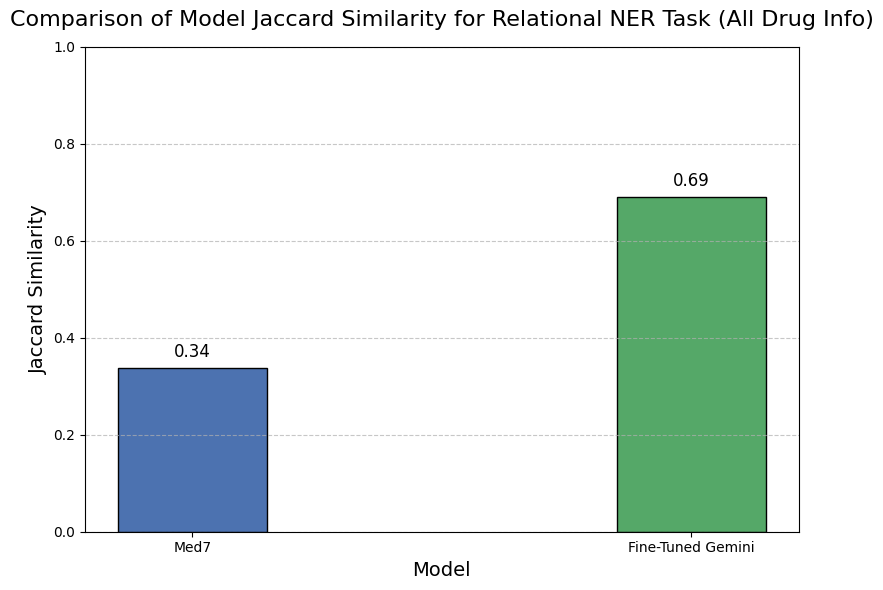

In [ ]:
import matplotlib.pyplot as plt

# Data; comparing relational NER for all relevant drug info
models = ["Med7", "Fine-Tuned Gemini"]
scores = [med7_mean_jac_sim_tuple, llm_mean_jac_sim_tuple]


colors = ["#4C72B0", "#55A868"]  # Nice blue and green

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(models, scores, color=colors, edgecolor="black", width=0.3)

ax.set_ylabel("Jaccard Similarity", fontsize=14)
ax.set_xlabel("Model", fontsize=14)
ax.set_title("Comparison of Model Jaccard Similarity for Relational NER Task (All Drug Info)", fontsize=16, pad=15)
ax.set_ylim(0, 1)  # Since Jaccard similarity is between 0 and 1
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
##Get the hand annotation ground truth and format it in usable tuples
hand_ann_files = ["gt_GB/26590365.json", "gt_GB/25987676.json", "gt_GB/28337573.json", "gt_GB/27119045.json", "gt_GB/23058381.json"]

all_jac_sims_med7_hand_anno = []
all_jac_sims_llm_hand_anno = []
#Computing jaccard with regards to LLM output
for i in range(len(test_df_reset)):
    if i != 2:
        ground_truth_dict = test_df_reset['hand_annotations_dict'].iloc[i]
        json_string = predictions_df['json_predictions'].iloc[i]
        index = json_string.find("{")
        json_string = json_string[index: ]

        if i == 1:
            index_end = json_string.find("PantoPRAZOLE")
            json_string = json_string[:index_end - 5] + "}"

        llm_dict = json_to_tuple(json_string)
        comparison_dict = compare_drug_dicts(llm_dict, ground_truth_dict)

        jac_sim = 0
        for tup in comparison_dict.values():
            jac_sim += tup[0]
        avg_jac_sim = jac_sim/len(comparison_dict)
        #print(avg_jac_sim)
        all_jac_sims_llm_hand_anno.append(avg_jac_sim)
llm_mean_jac_sim_tuple_hand_ann = np.mean(all_jac_sims_llm_hand_anno)
print(llm_mean_jac_sim_tuple_hand_ann)

#Computing jaccard with regards to med7 output
for i, file_name in enumerate(med_7_files):

    med7_tuple_dict = med7_to_tuple(file_name)

    med7_drugs = med7_tuple_dict.keys()

    ground_truth_dict = test_df_reset['hand_annotations_dict'].iloc[i]

    ground_truth_drugs = ground_truth_dict.keys()

    prop_sum += proportion_overlap(set(med7_drugs), set(ground_truth_drugs))

    med7_comparison_dict = compare_drug_dicts(med7_tuple_dict, ground_truth_dict)

    jac_sim = 0
    for tup in med7_comparison_dict.values():
        jac_sim += tup[0]
    avg_jac_sim = jac_sim/len(med7_comparison_dict)
    all_jac_sims_med7_hand_anno.append(avg_jac_sim)
med7_mean_jac_sim_tuple_hand_ann = np.mean(all_jac_sims_med7_hand_anno)
print(med7_mean_jac_sim_tuple_hand_ann)


0.3933673469387755
0.6887481481481481


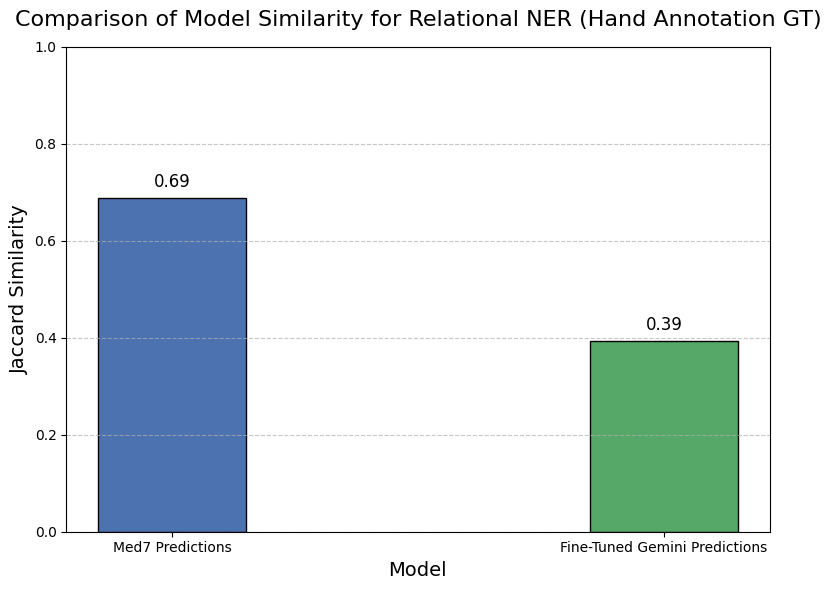

In [ ]:
import matplotlib.pyplot as plt

models = ["Med7 Predictions", "Fine-Tuned Gemini Predictions"]
scores = [med7_mean_jac_sim_tuple_hand_ann, llm_mean_jac_sim_tuple_hand_ann]


colors = ["#4C72B0", "#55A868"]  # Nice blue and green

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(models, scores, color=colors, edgecolor="black", width=0.3)

ax.set_ylabel("Jaccard Similarity", fontsize=14)
ax.set_xlabel("Model", fontsize=14)
ax.set_title("Comparison of Model Similarity for Relational NER (Hand Annotation GT)", fontsize=16, pad=15)
ax.set_ylim(0, 1)  # Since Jaccard similarity is between 0 and 1
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
##Compute jaccard similarity between hand anno and ehr:
avg_jac_sim_gt_comparison = []
for i in range(len(test_df_reset)):

    

    hand_anno_dict = test_df_reset['hand_annotations_dict'].iloc[i]
    ehr_ground_truth_dict = test_df_reset['meds_section_gt'].iloc[i]

    print(hand_anno_dict)
    print(ehr_ground_truth_dict)

    gt_comparison_dict = compare_drug_dicts(med7_tuple_dict, ground_truth_dict)

    jac_sim = 0
    for tup in gt_comparison_dict.values():
        jac_sim += tup[0]
    avg_jac_sim = jac_sim/len(gt_comparison_dict)
    print(avg_jac_sim)
    avg_jac_sim_gt_comparison.append(avg_jac_sim)
med7_mean_jac_sim_tuple_hand_ann = np.mean(avg_jac_sim_gt_comparison)
print(med7_mean_jac_sim_tuple_hand_ann)



{'metoprolol': [('5', 'mg', 'Not Mentioned', 'Not Mentioned'), ('100', 'mg', 'Not Mentioned', 'Not Mentioned')], 'lasix': [('40', 'mg', 'IV', 'Not Mentioned'), ('100', 'mg', 'PO', 'Not Mentioned')], 'torsemide': [('60', 'mg', 'PO', 'Tablet')], 'lopressor': [('5', 'mg', 'IV', 'Not Mentioned')], 'digoxin': [('0.0625', 'mg', 'PO', 'Tablet')], 'levoquin': [('500', 'mg', 'Not Mentioned', 'Not Mentioned')], 'coumadin': [('3', 'mg', 'Not Mentioned', 'Not Mentioned')], 'tylenol': [('Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned')], 'albuterol': [('Not Mentioned', 'Not Mentioned', 'nebs', 'Not Mentioned')], 'Aspirin': [('81', 'mg', 'Not Mentioned', 'Tablet')], 'Bisacodyl': [('10', 'mg', 'PO', 'Tablet')], 'Bupropin HCl': [('100', 'mg', 'PO', 'tablet')], 'Clobetasol': [('0.05', '%', 'Not Mentioned', 'Cream')], 'Cyanocobalamin': [('500', 'mcg', 'PO', 'Tablet')], 'Fexofenadine': [('60', 'mg', 'PO', 'Tablet')], 'Fluticasone-Salmeterol': [('100-50', 'mcg', 'PO', 'Dose')], 'Furosemi

In [ ]:
#how much missingingness in our hand annotations dataset
nested = test_df_reset['hand_annotations_dict'].iloc[0].values()
flattened_strings = [str(item) for tup in nested for pair in tup for item in pair]
print(flattened_strings)
count = 0
for val in flattened_strings:
    if val == 'Not Mentioned':
        count+=1
print(count/len(flattened_strings))

['5', 'mg', 'Not Mentioned', 'Not Mentioned', '100', 'mg', 'Not Mentioned', 'Not Mentioned', '40', 'mg', 'IV', 'Not Mentioned', '100', 'mg', 'PO', 'Not Mentioned', '60', 'mg', 'PO', 'Tablet', '5', 'mg', 'IV', 'Not Mentioned', '0.0625', 'mg', 'PO', 'Tablet', '500', 'mg', 'Not Mentioned', 'Not Mentioned', '3', 'mg', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'Not Mentioned', 'nebs', 'Not Mentioned', '81', 'mg', 'Not Mentioned', 'Tablet', '10', 'mg', 'PO', 'Tablet', '100', 'mg', 'PO', 'tablet', '0.05', '%', 'Not Mentioned', 'Cream', '500', 'mcg', 'PO', 'Tablet', '60', 'mg', 'PO', 'Tablet', '100-50', 'mcg', 'PO', 'Dose', '100', 'mcg', 'Not Mentioned', 'Tablet', '22', 'units', 'subcutaneous', 'Not Mentioned', 'Not Mentioned', 'units', 'subcutaneous', 'Not Mentioned', '0.02', '%', 'neb', 'Solution', '225', 'mcg', 'PO', 'Tablet', '75', 'mg', 'PO', 'Tablet', '30', 'mg', 'Not Mentioned', 'Not Mentioned', '10/5', 'mg/mL'

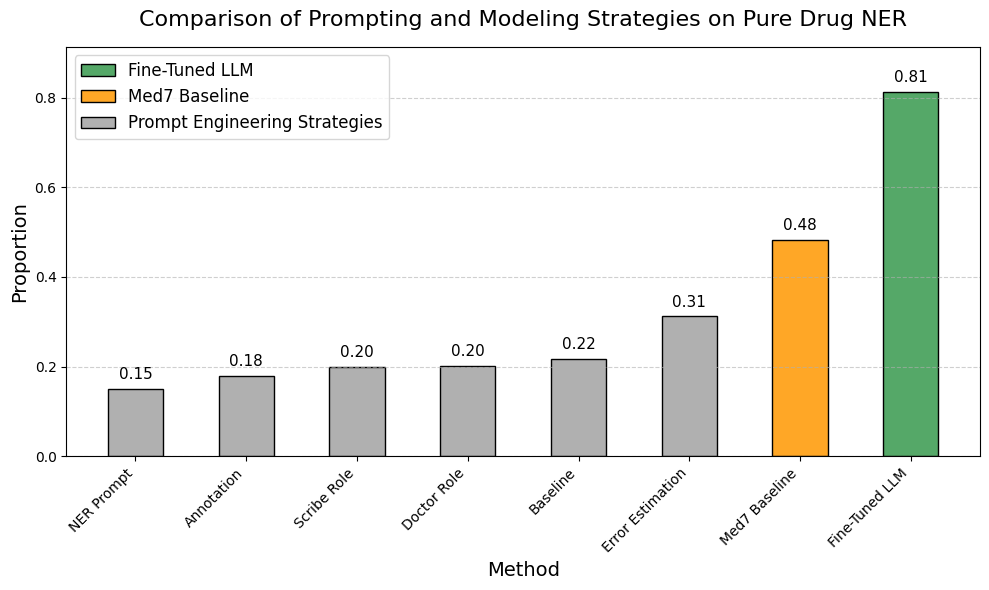

In [ ]:
##Pure NER on drug categories plotting
import matplotlib.pyplot as plt

llm_prop = np.mean([0.824, 0.539, 1.0, 0.889]) #from fine-tuning jupyter notebook

all_props = [("Baseline", baseline_prop), 
             ("Annotation", annotation_prop), 
             ("Doctor Role", doctor_prop), 
             ("Error Estimation", error_prop), 
             ("Scribe Role", scribe_prop), 
             ("NER Prompt", ner_prop), 
             ("Fine-Tuned LLM", llm_prop), 
             ("Med7 Baseline", med7_prop)] #have to recreate these above by file name changing basically in cells 3 and 5; med7_prop is created in just the previous cell



sorted_props = sorted(all_props, key=lambda x: x[1])
labels, values = zip(*sorted_props)

colors = []
for label in labels:
    if label == "Fine-Tuned LLM":
        colors.append("#55A868")  # greenish for LLM
    elif label == "Med7 Baseline":
        colors.append("#FFA726")  # orange for Med7
    else:
        colors.append("#B0B0B0")  # gray for others

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values, color=colors, edgecolor="black", width=0.5)

ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("Method", fontsize=14)
ax.set_title("Comparison of Prompting and Modeling Strategies on Pure Drug NER", fontsize=16, pad=15)
ax.set_ylim(0, max(values) + 0.1)
ax.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#55A868", edgecolor='black', label='Fine-Tuned LLM'),
    Patch(facecolor="#FFA726", edgecolor='black', label='Med7 Baseline'),
    Patch(facecolor="#B0B0B0", edgecolor='black', label='Prompt Engineering Strategies')
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





In [ ]:
##injecting a proportion (~23%) of "Not Mentioned" values randomly in the ground truth labels
##This will be fed into fine-tuning and model output frequency of "Not Mentioned" will be recorded
import random

def randomly_mask_values(drug_dict, p=0.25, seed=None):
    """
    Replace elements in 4-tuples with "Not Mentioned" at proportion p.
    
    Args:
        drug_dict (dict): {drug: list of 4-tuples}
        p (float): Probability of replacing any given element
        seed (int, optional): Seed for reproducibility

    Returns:
        dict: New dictionary with some elements masked
    """
    if seed is not None:
        random.seed(seed)

    masked_dict = {}
    for drug, tuples in drug_dict.items():
        new_tuples = []
        for tup in tuples:
            new_tup = tuple(
                val if random.random() > p else "Not Mentioned"
                for val in tup
            )
            new_tuples.append(new_tup)
        masked_dict[drug] = new_tuples
    return masked_dict


masked_dict_list = []
for i in range(len(train_df_reset)):
    test_null_dict = randomly_mask_values(train_df_reset['meds_section_gt'].iloc[i], seed = 702)
    masked_dict_list.append(test_null_dict)

train_df_reset['null_injected_gt'] = masked_dict_list

#convert these dictionary type objects to json format
json_outputs = []
for i in range(len(train_df_reset)):
    data = train_df_reset['null_injected_gt'].iloc[i]

    fields = ["Drug Dosage", "Unit of Dosage", "Route", "Drug Form"]

    ## convert each tuple to a dictionary with the right keys
    json_ready = {
        drug: [dict(zip(fields, mention)) for mention in mentions]
        for drug, mentions in data.items()
    }

    ##convert to JSON string
    json_output = json.dumps(json_ready, indent=2)
    json_outputs.append(json_output)
train_df_reset['null_injected_gt'] = json_outputs

In [188]:
train_df_reset[['text', 'meds_section', 'meds_section_gt', 'null_injected_gt']].to_csv("train_relational_null_injected.csv")